# Comparative SDG Prediction with XGBoost (GPU-Accelerated)

## Predicting All SDG Indicators Using Satellite Embeddings

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/ds4bolivia/blob/master/notebooks/predict_all_sdgs_xgb_optuna_cv.ipynb)

---

### Overview

This notebook performs a **comprehensive comparative analysis** of how well satellite imagery embeddings can predict different Sustainable Development Goal (SDG) indicators across Bolivia's 339 municipalities.

**Research Question**: Which SDG dimensions are most predictable from satellite imagery, and what does this tell us about the relationship between visible landscape features and human development outcomes?

### Methodology

- **Algorithm**: XGBoost with automatic GPU detection
- **Hyperparameter Tuning**: Optuna with Bayesian optimization (TPE sampler)
- **Evaluation**: Nested cross-validation (5 outer folds × 3 inner folds)
- **Features**: 64-dimensional satellite embeddings from Google Earth Engine
- **Targets**: 16 SDG indicators (IMDS + 15 individual SDG indices)

### Why This Approach?

| Component | Purpose |
|-----------|--------|
| **XGBoost** | State-of-the-art gradient boosting, often outperforms Random Forest |
| **GPU acceleration** | 10-50x speedup enables comprehensive analysis (auto-detected) |
| **Optuna** | Efficient Bayesian hyperparameter search with pruning |
| **Nested CV** | Unbiased performance estimates with confidence intervals |

### Expected Runtime

- **A100 GPU**: ~15-30 minutes
- **T4 GPU**: ~30-60 minutes
- **CPU only**: ~2-4 hours

---

## 1. Setup & Environment Configuration

First, let's verify GPU availability and install the required packages.

In [1]:
# Check GPU availability
!nvidia-smi

Fri Jan 16 06:20:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Install required packages with GPU-compatible XGBoost
# XGBoost 2.0+ has a different API for GPU, so we install a compatible version
!pip install -q "xgboost>=2.0.0" optuna plotly kaleido tqdm

# Verify installation
import xgboost as xgb
print(f"XGBoost version installed: {xgb.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.0 MB/s eta 0:00:00
XGBoost version installed: 3.1.2


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.auto import tqdm
import warnings
import json
import time

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Verify XGBoost version and GPU support
print(f"XGBoost version: {xgb.__version__}")
print(f"Optuna version: {optuna.__version__}")

XGBoost version: 3.1.2
Optuna version: 4.6.0


In [4]:
# Test XGBoost GPU functionality
# XGBoost 2.0+ uses 'device' parameter instead of 'tree_method=gpu_hist'
# For older versions, we fall back to 'tree_method=gpu_hist'

import subprocess

def detect_gpu_params():
    """
    Detect the correct XGBoost GPU parameters based on version and availability.
    Returns a dict of parameters to use for GPU acceleration.
    """
    xgb_version = tuple(map(int, xgb.__version__.split('.')[:2]))

    # Check if CUDA is available
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        cuda_available = result.returncode == 0
    except:
        cuda_available = False

    if not cuda_available:
        print("No NVIDIA GPU detected. Using CPU.")
        return {'tree_method': 'hist'}, False

    # Try XGBoost 2.0+ API first (device='cuda')
    if xgb_version >= (2, 0):
        try:
            test_model = xgb.XGBRegressor(
                device='cuda',
                tree_method='hist',
                n_estimators=10,
                verbosity=0
            )
            test_X = np.random.rand(100, 10)
            test_y = np.random.rand(100)
            test_model.fit(test_X, test_y)
            print(f"✓ GPU acceleration enabled (XGBoost {xgb.__version__}, device='cuda')")
            return {'device': 'cuda', 'tree_method': 'hist'}, True
        except Exception as e:
            print(f"XGBoost 2.0+ GPU failed: {e}")

    # Try legacy API (tree_method='gpu_hist')
    try:
        test_model = xgb.XGBRegressor(
            tree_method='gpu_hist',
            n_estimators=10,
            verbosity=0
        )
        test_X = np.random.rand(100, 10)
        test_y = np.random.rand(100)
        test_model.fit(test_X, test_y)
        print(f"✓ GPU acceleration enabled (XGBoost {xgb.__version__}, tree_method='gpu_hist')")
        return {'tree_method': 'gpu_hist'}, True
    except Exception as e:
        print(f"Legacy GPU API failed: {e}")

    # Fall back to CPU
    print("GPU not available, using CPU (tree_method='hist')")
    return {'tree_method': 'hist'}, False

# Detect GPU configuration
GPU_PARAMS, GPU_AVAILABLE = detect_gpu_params()
print(f"\nGPU Parameters: {GPU_PARAMS}")
print(f"GPU Available: {GPU_AVAILABLE}")

✓ GPU acceleration enabled (XGBoost 3.1.2, device='cuda')

GPU Parameters: {'device': 'cuda', 'tree_method': 'hist'}
GPU Available: True


## 2. Data Loading & Preprocessing

We load three datasets from the DS4Bolivia repository:
1. **SDG indices** - Our 16 target variables
2. **Satellite embeddings** - Our 64 feature variables
3. **Region names** - For interpretation of results

In [5]:
# Load datasets from GitHub
print("Loading datasets...")

# SDG indices (contains all target variables)
url_sdg = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master/sdg/sdg.csv"
df_sdg = pd.read_csv(url_sdg)
print(f"  SDG data: {df_sdg.shape[0]} municipalities, {df_sdg.shape[1]} columns")

# Satellite embeddings (64-dimensional features)
url_emb = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master/satelliteEmbeddings/satelliteEmbeddings2017.csv"
df_embeddings = pd.read_csv(url_emb)
print(f"  Satellite embeddings: {df_embeddings.shape[0]} municipalities, {df_embeddings.shape[1]} columns")

# Region names for interpretation
url_names = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master/regionNames/regionNames.csv"
df_names = pd.read_csv(url_names)
print(f"  Region names: {df_names.shape[0]} municipalities")

Loading datasets...
  SDG data: 339 municipalities, 17 columns
  Satellite embeddings: 339 municipalities, 65 columns
  Region names: 339 municipalities


In [6]:
# Define target variables (all SDG indicators)
TARGET_VARIABLES = [
    'imds',          # Municipal Sustainable Development Index (composite)
    'index_sdg1',    # No Poverty
    'index_sdg2',    # Zero Hunger
    'index_sdg3',    # Good Health and Well-being
    'index_sdg4',    # Quality Education
    'index_sdg5',    # Gender Equality
    'index_sdg6',    # Clean Water and Sanitation
    'index_sdg7',    # Affordable and Clean Energy
    'index_sdg8',    # Decent Work and Economic Growth
    'index_sdg9',    # Industry, Innovation and Infrastructure
    'index_sdg10',   # Reduced Inequalities
    'index_sdg11',   # Sustainable Cities and Communities
    'index_sdg13',   # Climate Action
    'index_sdg15',   # Life on Land
    'index_sdg16',   # Peace, Justice and Strong Institutions
    'index_sdg17',   # Partnerships for the Goals
]

# SDG descriptions for visualization
SDG_DESCRIPTIONS = {
    'imds': 'IMDS (Composite)',
    'index_sdg1': 'SDG 1: No Poverty',
    'index_sdg2': 'SDG 2: Zero Hunger',
    'index_sdg3': 'SDG 3: Good Health',
    'index_sdg4': 'SDG 4: Quality Education',
    'index_sdg5': 'SDG 5: Gender Equality',
    'index_sdg6': 'SDG 6: Clean Water',
    'index_sdg7': 'SDG 7: Clean Energy',
    'index_sdg8': 'SDG 8: Decent Work',
    'index_sdg9': 'SDG 9: Innovation',
    'index_sdg10': 'SDG 10: Reduced Inequalities',
    'index_sdg11': 'SDG 11: Sustainable Cities',
    'index_sdg13': 'SDG 13: Climate Action',
    'index_sdg15': 'SDG 15: Life on Land',
    'index_sdg16': 'SDG 16: Peace & Justice',
    'index_sdg17': 'SDG 17: Partnerships',
}

# SDG categories for grouped analysis
SDG_CATEGORIES = {
    'imds': 'Composite',
    'index_sdg1': 'Economic',
    'index_sdg2': 'Social',
    'index_sdg3': 'Social',
    'index_sdg4': 'Social',
    'index_sdg5': 'Social',
    'index_sdg6': 'Environmental',
    'index_sdg7': 'Environmental',
    'index_sdg8': 'Economic',
    'index_sdg9': 'Economic',
    'index_sdg10': 'Economic',
    'index_sdg11': 'Environmental',
    'index_sdg13': 'Environmental',
    'index_sdg15': 'Environmental',
    'index_sdg16': 'Governance',
    'index_sdg17': 'Governance',
}

print(f"\nTarget variables: {len(TARGET_VARIABLES)}")
for var in TARGET_VARIABLES:
    print(f"  - {var}: {SDG_DESCRIPTIONS[var]}")


Target variables: 16
  - imds: IMDS (Composite)
  - index_sdg1: SDG 1: No Poverty
  - index_sdg2: SDG 2: Zero Hunger
  - index_sdg3: SDG 3: Good Health
  - index_sdg4: SDG 4: Quality Education
  - index_sdg5: SDG 5: Gender Equality
  - index_sdg6: SDG 6: Clean Water
  - index_sdg7: SDG 7: Clean Energy
  - index_sdg8: SDG 8: Decent Work
  - index_sdg9: SDG 9: Innovation
  - index_sdg10: SDG 10: Reduced Inequalities
  - index_sdg11: SDG 11: Sustainable Cities
  - index_sdg13: SDG 13: Climate Action
  - index_sdg15: SDG 15: Life on Land
  - index_sdg16: SDG 16: Peace & Justice
  - index_sdg17: SDG 17: Partnerships


In [7]:
# Merge datasets
df_merged = df_sdg.merge(
    df_embeddings,
    on='asdf_id',
    how='inner'
)
df_merged = df_merged.merge(
    df_names[['asdf_id', 'mun', 'dep']],
    on='asdf_id',
    how='left'
)

print(f"Merged dataset: {df_merged.shape[0]} municipalities")

# Define feature columns (satellite embeddings)
FEATURE_COLS = [f'A{str(i).zfill(2)}' for i in range(64)]
print(f"Feature columns: {len(FEATURE_COLS)} satellite embeddings (A00-A63)")

Merged dataset: 339 municipalities
Feature columns: 64 satellite embeddings (A00-A63)


In [8]:
# Analyze data availability for each target variable
print("\nData availability per SDG indicator:")
print("-" * 60)

data_availability = []
for var in TARGET_VARIABLES:
    n_valid = df_merged[var].notna().sum()
    n_missing = df_merged[var].isna().sum()
    pct_valid = n_valid / len(df_merged) * 100

    if n_valid > 0:
        var_mean = df_merged[var].mean()
        var_std = df_merged[var].std()
    else:
        var_mean = var_std = np.nan

    data_availability.append({
        'variable': var,
        'description': SDG_DESCRIPTIONS[var],
        'n_valid': n_valid,
        'n_missing': n_missing,
        'pct_valid': pct_valid,
        'mean': var_mean,
        'std': var_std
    })

    print(f"{SDG_DESCRIPTIONS[var]:<30} | Valid: {n_valid:>3} | Missing: {n_missing:>3} | Mean: {var_mean:>6.2f} | Std: {var_std:>5.2f}")

df_availability = pd.DataFrame(data_availability)


Data availability per SDG indicator:
------------------------------------------------------------
IMDS (Composite)               | Valid: 339 | Missing:   0 | Mean:  51.05 | Std:  6.77
SDG 1: No Poverty              | Valid: 339 | Missing:   0 | Mean:  37.46 | Std: 20.95
SDG 2: Zero Hunger             | Valid: 339 | Missing:   0 | Mean:  40.68 | Std: 11.05
SDG 3: Good Health             | Valid: 339 | Missing:   0 | Mean:  75.21 | Std:  7.36
SDG 4: Quality Education       | Valid: 339 | Missing:   0 | Mean:  53.25 | Std: 12.11
SDG 5: Gender Equality         | Valid: 339 | Missing:   0 | Mean:  73.06 | Std:  9.72
SDG 6: Clean Water             | Valid: 339 | Missing:   0 | Mean:  35.80 | Std: 16.23
SDG 7: Clean Energy            | Valid: 339 | Missing:   0 | Mean:  52.26 | Std: 14.93
SDG 8: Decent Work             | Valid: 339 | Missing:   0 | Mean:  44.98 | Std: 10.51
SDG 9: Innovation              | Valid: 339 | Missing:   0 | Mean:  35.53 | Std: 15.20
SDG 10: Reduced Inequalities   

## 3. XGBoost Configuration & Optuna Objective Function

### Understanding the Hyperparameter Search Space

XGBoost has many hyperparameters that control model complexity and regularization:

| Parameter | Range | Purpose |
|-----------|-------|--------|
| `n_estimators` | [100, 1000] | Number of boosting rounds |
| `max_depth` | [3, 15] | Maximum tree depth (complexity) |
| `learning_rate` | [0.01, 0.3] | Step size shrinkage (η) |
| `min_child_weight` | [1, 10] | Minimum sum of instance weight in a child |
| `subsample` | [0.6, 1.0] | Row subsampling ratio |
| `colsample_bytree` | [0.6, 1.0] | Column subsampling ratio |
| `reg_alpha` | [1e-8, 10] | L1 regularization (Lasso) |
| `reg_lambda` | [1e-8, 10] | L2 regularization (Ridge) |
| `gamma` | [1e-8, 5] | Minimum loss reduction for split |

In [9]:
def create_objective(X_train_fold, y_train_fold, inner_cv):
    """
    Factory function that creates an Optuna objective for a specific training fold.

    This pattern is necessary because:
    1. Optuna's objective function only takes a 'trial' parameter
    2. We need to pass fold-specific training data
    3. The closure captures X_train_fold and y_train_fold

    Parameters:
    -----------
    X_train_fold : array-like
        Features for this outer fold's training set
    y_train_fold : array-like
        Target for this outer fold's training set
    inner_cv : KFold
        Cross-validation splitter for inner loop

    Returns:
    --------
    objective : function
        Objective function for Optuna optimization
    """

    def objective(trial):
        # Sample hyperparameters from search space
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500, step=50),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'gamma': trial.suggest_float('gamma', 1e-8, 5.0, log=True),
            # Fixed parameters - use detected GPU params
            **GPU_PARAMS,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'random_state': RANDOM_STATE,
        }

        # Create model with sampled parameters
        model = xgb.XGBRegressor(**params)

        # Evaluate using inner cross-validation
        try:
            cv_scores = cross_val_score(
                model, X_train_fold, y_train_fold,
                cv=inner_cv,
                scoring='r2',
                n_jobs=1  # GPU handles parallelism
            )
            return cv_scores.mean()
        except Exception as e:
            # Return a very low score if model fails
            return -1.0

    return objective

In [10]:
def run_nested_cv_for_target(X, y, target_name, n_outer_folds=5, n_inner_folds=5, n_trials=50):
    """
    Run nested cross-validation with Optuna hyperparameter tuning for a single target.

    Nested CV Structure:
    - Outer loop: K-fold CV for unbiased performance estimation
      - Inner loop: K-fold CV within Optuna for hyperparameter tuning

    Parameters:
    -----------
    X : array-like
        Feature matrix (n_samples, 64)
    y : array-like
        Target variable (n_samples,)
    target_name : str
        Name of the target variable (for logging)
    n_outer_folds : int
        Number of outer CV folds
    n_inner_folds : int
        Number of inner CV folds for Optuna
    n_trials : int
        Number of Optuna trials per outer fold

    Returns:
    --------
    results : dict
        Dictionary containing metrics, best params, and predictions
    """

    # Setup cross-validation
    outer_cv = KFold(n_splits=n_outer_folds, shuffle=True, random_state=RANDOM_STATE)
    inner_cv = KFold(n_splits=n_inner_folds, shuffle=True, random_state=RANDOM_STATE)

    # Storage for results
    fold_r2_scores = []
    fold_rmse_scores = []
    fold_mae_scores = []
    fold_best_params = []
    all_predictions = np.zeros_like(y)
    all_feature_importances = []

    # Outer cross-validation loop
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):

        # Split data for this outer fold
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        # Create Optuna study for this fold
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=RANDOM_STATE + fold_idx),
            pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3)
        )

        # Create objective function for this fold
        objective = create_objective(X_train_fold, y_train_fold, inner_cv)

        # Run optimization
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

        # Get best parameters
        best_params = study.best_params.copy()
        best_params.update({
            **GPU_PARAMS,
            'objective': 'reg:squarederror',
            'verbosity': 0,
            'random_state': RANDOM_STATE,
        })
        fold_best_params.append(best_params)

        # Train final model with best parameters on full training fold
        final_model = xgb.XGBRegressor(**best_params)
        final_model.fit(X_train_fold, y_train_fold)

        # Evaluate on test fold
        y_pred = final_model.predict(X_test_fold)
        all_predictions[test_idx] = y_pred

        # Calculate metrics
        fold_r2 = r2_score(y_test_fold, y_pred)
        fold_rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))
        fold_mae = mean_absolute_error(y_test_fold, y_pred)

        fold_r2_scores.append(fold_r2)
        fold_rmse_scores.append(fold_rmse)
        fold_mae_scores.append(fold_mae)

        # Store feature importances
        all_feature_importances.append(final_model.feature_importances_)

    # Aggregate results
    r2_mean = np.mean(fold_r2_scores)
    r2_std = np.std(fold_r2_scores)
    r2_ci_lower = r2_mean - 1.96 * r2_std / np.sqrt(n_outer_folds)
    r2_ci_upper = r2_mean + 1.96 * r2_std / np.sqrt(n_outer_folds)

    rmse_mean = np.mean(fold_rmse_scores)
    rmse_std = np.std(fold_rmse_scores)

    mae_mean = np.mean(fold_mae_scores)
    mae_std = np.std(fold_mae_scores)

    # Average feature importances across folds
    avg_feature_importances = np.mean(all_feature_importances, axis=0)

    return {
        'target': target_name,
        'n_samples': len(y),
        'r2_mean': r2_mean,
        'r2_std': r2_std,
        'r2_ci_lower': r2_ci_lower,
        'r2_ci_upper': r2_ci_upper,
        'rmse_mean': rmse_mean,
        'rmse_std': rmse_std,
        'mae_mean': mae_mean,
        'mae_std': mae_std,
        'fold_r2_scores': fold_r2_scores,
        'fold_rmse_scores': fold_rmse_scores,
        'fold_mae_scores': fold_mae_scores,
        'best_params_per_fold': fold_best_params,
        'predictions': all_predictions,
        'feature_importances': avg_feature_importances,
    }

## 4. Main Execution: Predict All SDG Indicators

Now we run the nested cross-validation with Optuna for all 16 SDG indicators. This is the computationally intensive part of the notebook.

**Configuration:**
- 5 outer folds × 3 inner folds × 50 trials = 750 model fits per SDG
- 16 SDGs × 750 = 12,000 total model fits
- With GPU acceleration, this takes ~15-30 minutes on A100
- Without GPU (CPU only), expect 2-4 hours

In [11]:
# Configuration for nested CV
# Reduced from original to speed up execution while maintaining rigor
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 3  # Reduced from 5 to speed up inner optimization
N_TRIALS = 50      # Reduced from 100 - still provides good optimization

# Calculate total model fits
total_fits = len(TARGET_VARIABLES) * N_OUTER_FOLDS * N_TRIALS * N_INNER_FOLDS

print("="*80)
print("COMPARATIVE SDG PREDICTION WITH XGBOOST")
print("="*80)
print(f"\nConfiguration:")
print(f"  - Outer CV folds: {N_OUTER_FOLDS}")
print(f"  - Inner CV folds: {N_INNER_FOLDS}")
print(f"  - Optuna trials per fold: {N_TRIALS}")
print(f"  - Target variables: {len(TARGET_VARIABLES)}")
print(f"  - Total model fits (estimated): {total_fits:,}")
print(f"  - GPU acceleration: {GPU_AVAILABLE}")
print(f"  - GPU parameters: {GPU_PARAMS}")

# Estimate runtime
if GPU_AVAILABLE:
    est_time = "15-30 minutes"
else:
    est_time = "2-4 hours"
print(f"  - Estimated runtime: {est_time}")
print()

COMPARATIVE SDG PREDICTION WITH XGBOOST

Configuration:
  - Outer CV folds: 5
  - Inner CV folds: 3
  - Optuna trials per fold: 50
  - Target variables: 16
  - Total model fits (estimated): 12,000
  - GPU acceleration: True
  - GPU parameters: {'device': 'cuda', 'tree_method': 'hist'}
  - Estimated runtime: 15-30 minutes



In [12]:
# Run prediction for all SDG indicators
all_results = []
feature_importance_matrix = []  # 16 SDGs × 64 features

start_time = time.time()

for i, target_var in enumerate(tqdm(TARGET_VARIABLES, desc="Processing SDGs")):

    print(f"\n[{i+1}/{len(TARGET_VARIABLES)}] Processing {SDG_DESCRIPTIONS[target_var]}...")

    # Prepare data for this target (remove missing values)
    mask = df_merged[target_var].notna()
    X = df_merged.loc[mask, FEATURE_COLS].values
    y = df_merged.loc[mask, target_var].values

    if len(y) < 50:  # Skip if too few samples
        print(f"  Skipping: only {len(y)} valid samples")
        continue

    # Run nested CV with Optuna
    target_start = time.time()
    results = run_nested_cv_for_target(
        X, y, target_var,
        n_outer_folds=N_OUTER_FOLDS,
        n_inner_folds=N_INNER_FOLDS,
        n_trials=N_TRIALS
    )
    target_time = time.time() - target_start

    # Add metadata
    results['description'] = SDG_DESCRIPTIONS[target_var]
    results['category'] = SDG_CATEGORIES[target_var]
    results['time_seconds'] = target_time

    all_results.append(results)
    feature_importance_matrix.append(results['feature_importances'])

    # Print progress
    print(f"  R² = {results['r2_mean']:.4f} (±{results['r2_std']:.4f}) | "
          f"MAE = {results['mae_mean']:.2f} | "
          f"Time: {target_time:.1f}s")

total_time = time.time() - start_time
print(f"\n{'='*80}")
print(f"Total execution time: {total_time/60:.1f} minutes")
print(f"{'='*80}")

Processing SDGs:   0%|          | 0/16 [00:00<?, ?it/s]


[1/16] Processing IMDS (Composite)...
  R² = 0.2209 (±0.1747) | MAE = 4.48 | Time: 269.8s

[2/16] Processing SDG 1: No Poverty...
  R² = 0.3973 (±0.1337) | MAE = 12.43 | Time: 301.4s

[3/16] Processing SDG 2: Zero Hunger...
  R² = 0.4942 (±0.0742) | MAE = 5.58 | Time: 267.9s

[4/16] Processing SDG 3: Good Health...
  R² = 0.2535 (±0.0669) | MAE = 5.00 | Time: 325.4s

[5/16] Processing SDG 4: Quality Education...
  R² = 0.3489 (±0.0840) | MAE = 7.57 | Time: 305.6s

[6/16] Processing SDG 5: Gender Equality...
  R² = 0.2262 (±0.1245) | MAE = 6.44 | Time: 236.0s

[7/16] Processing SDG 6: Clean Water...
  R² = 0.1699 (±0.1250) | MAE = 10.75 | Time: 242.9s

[8/16] Processing SDG 7: Clean Energy...
  R² = 0.3473 (±0.1270) | MAE = 9.44 | Time: 327.0s

[9/16] Processing SDG 8: Decent Work...
  R² = 0.3166 (±0.1367) | MAE = 6.79 | Time: 302.0s

[10/16] Processing SDG 9: Innovation...
  R² = 0.2072 (±0.1070) | MAE = 10.46 | Time: 250.1s

[11/16] Processing SDG 10: Reduced Inequalities...
  R² = 

## 5. Results Compilation

Let's compile all results into a structured DataFrame and rank the SDGs by predictive power.

In [13]:
# Create results DataFrame
results_data = []

for r in all_results:
    results_data.append({
        'variable': r['target'],
        'description': r['description'],
        'category': r['category'],
        'n_samples': r['n_samples'],
        'r2_mean': r['r2_mean'],
        'r2_std': r['r2_std'],
        'r2_ci_lower': r['r2_ci_lower'],
        'r2_ci_upper': r['r2_ci_upper'],
        'rmse_mean': r['rmse_mean'],
        'rmse_std': r['rmse_std'],
        'mae_mean': r['mae_mean'],
        'mae_std': r['mae_std'],
        'time_seconds': r['time_seconds'],
    })

df_results = pd.DataFrame(results_data)

# Add ranking
df_results['rank'] = df_results['r2_mean'].rank(ascending=False).astype(int)
df_results = df_results.sort_values('rank')

# Add predictability category
def categorize_predictability(r2):
    if r2 >= 0.4:
        return 'High'
    elif r2 >= 0.25:
        return 'Medium'
    elif r2 >= 0.1:
        return 'Low'
    else:
        return 'Very Low'

df_results['predictability'] = df_results['r2_mean'].apply(categorize_predictability)

In [14]:
# Display summary table
print("\n" + "="*100)
print("COMPARATIVE RESULTS: SDG PREDICTABILITY FROM SATELLITE EMBEDDINGS")
print("="*100)
print()

# Format for display
display_cols = ['rank', 'description', 'category', 'n_samples', 'r2_mean', 'r2_std', 'mae_mean', 'predictability']
df_display = df_results[display_cols].copy()
df_display.columns = ['Rank', 'SDG', 'Category', 'N', 'R² Mean', 'R² Std', 'MAE', 'Predictability']

# Print table
print(df_display.to_string(index=False))


COMPARATIVE RESULTS: SDG PREDICTABILITY FROM SATELLITE EMBEDDINGS

 Rank                          SDG      Category   N   R² Mean   R² Std       MAE Predictability
    1 SDG 10: Reduced Inequalities      Economic 339  0.587309 0.049369  6.974529           High
    2       SDG 13: Climate Action Environmental 339  0.549976 0.039247  7.071523           High
    3           SDG 2: Zero Hunger        Social 339  0.494248 0.074167  5.578314           High
    4            SDG 1: No Poverty      Economic 339  0.397340 0.133684 12.434066         Medium
    5     SDG 4: Quality Education        Social 339  0.348914 0.083970  7.570637         Medium
    6          SDG 7: Clean Energy Environmental 339  0.347348 0.126962  9.437402         Medium
    7           SDG 8: Decent Work      Economic 339  0.316605 0.136737  6.791999         Medium
    8           SDG 3: Good Health        Social 339  0.253504 0.066882  5.003586         Medium
    9       SDG 5: Gender Equality        Social 339  0.226

In [15]:
# Summary statistics by category
print("\n" + "="*80)
print("PREDICTABILITY BY SDG CATEGORY")
print("="*80)

category_summary = df_results.groupby('category').agg({
    'r2_mean': ['mean', 'std', 'min', 'max'],
    'mae_mean': 'mean',
    'variable': 'count'
}).round(4)

category_summary.columns = ['R² Mean', 'R² Std', 'R² Min', 'R² Max', 'MAE Mean', 'Count']
print(category_summary.sort_values('R² Mean', ascending=False))


PREDICTABILITY BY SDG CATEGORY
               R² Mean  R² Std  R² Min  R² Max  MAE Mean  Count
category                                                       
Economic        0.3771  0.1603  0.2072  0.5873    9.1650      4
Social          0.3307  0.1210  0.2262  0.4942    6.1486      4
Environmental   0.2915  0.1608  0.1699  0.5500    9.3527      5
Composite       0.2209     NaN  0.2209  0.2209    4.4806      1
Governance      0.0499  0.1426 -0.0509  0.1507    7.6035      2


## 6. Visualizations

Let's create comprehensive visualizations to understand the comparative predictability of different SDGs.

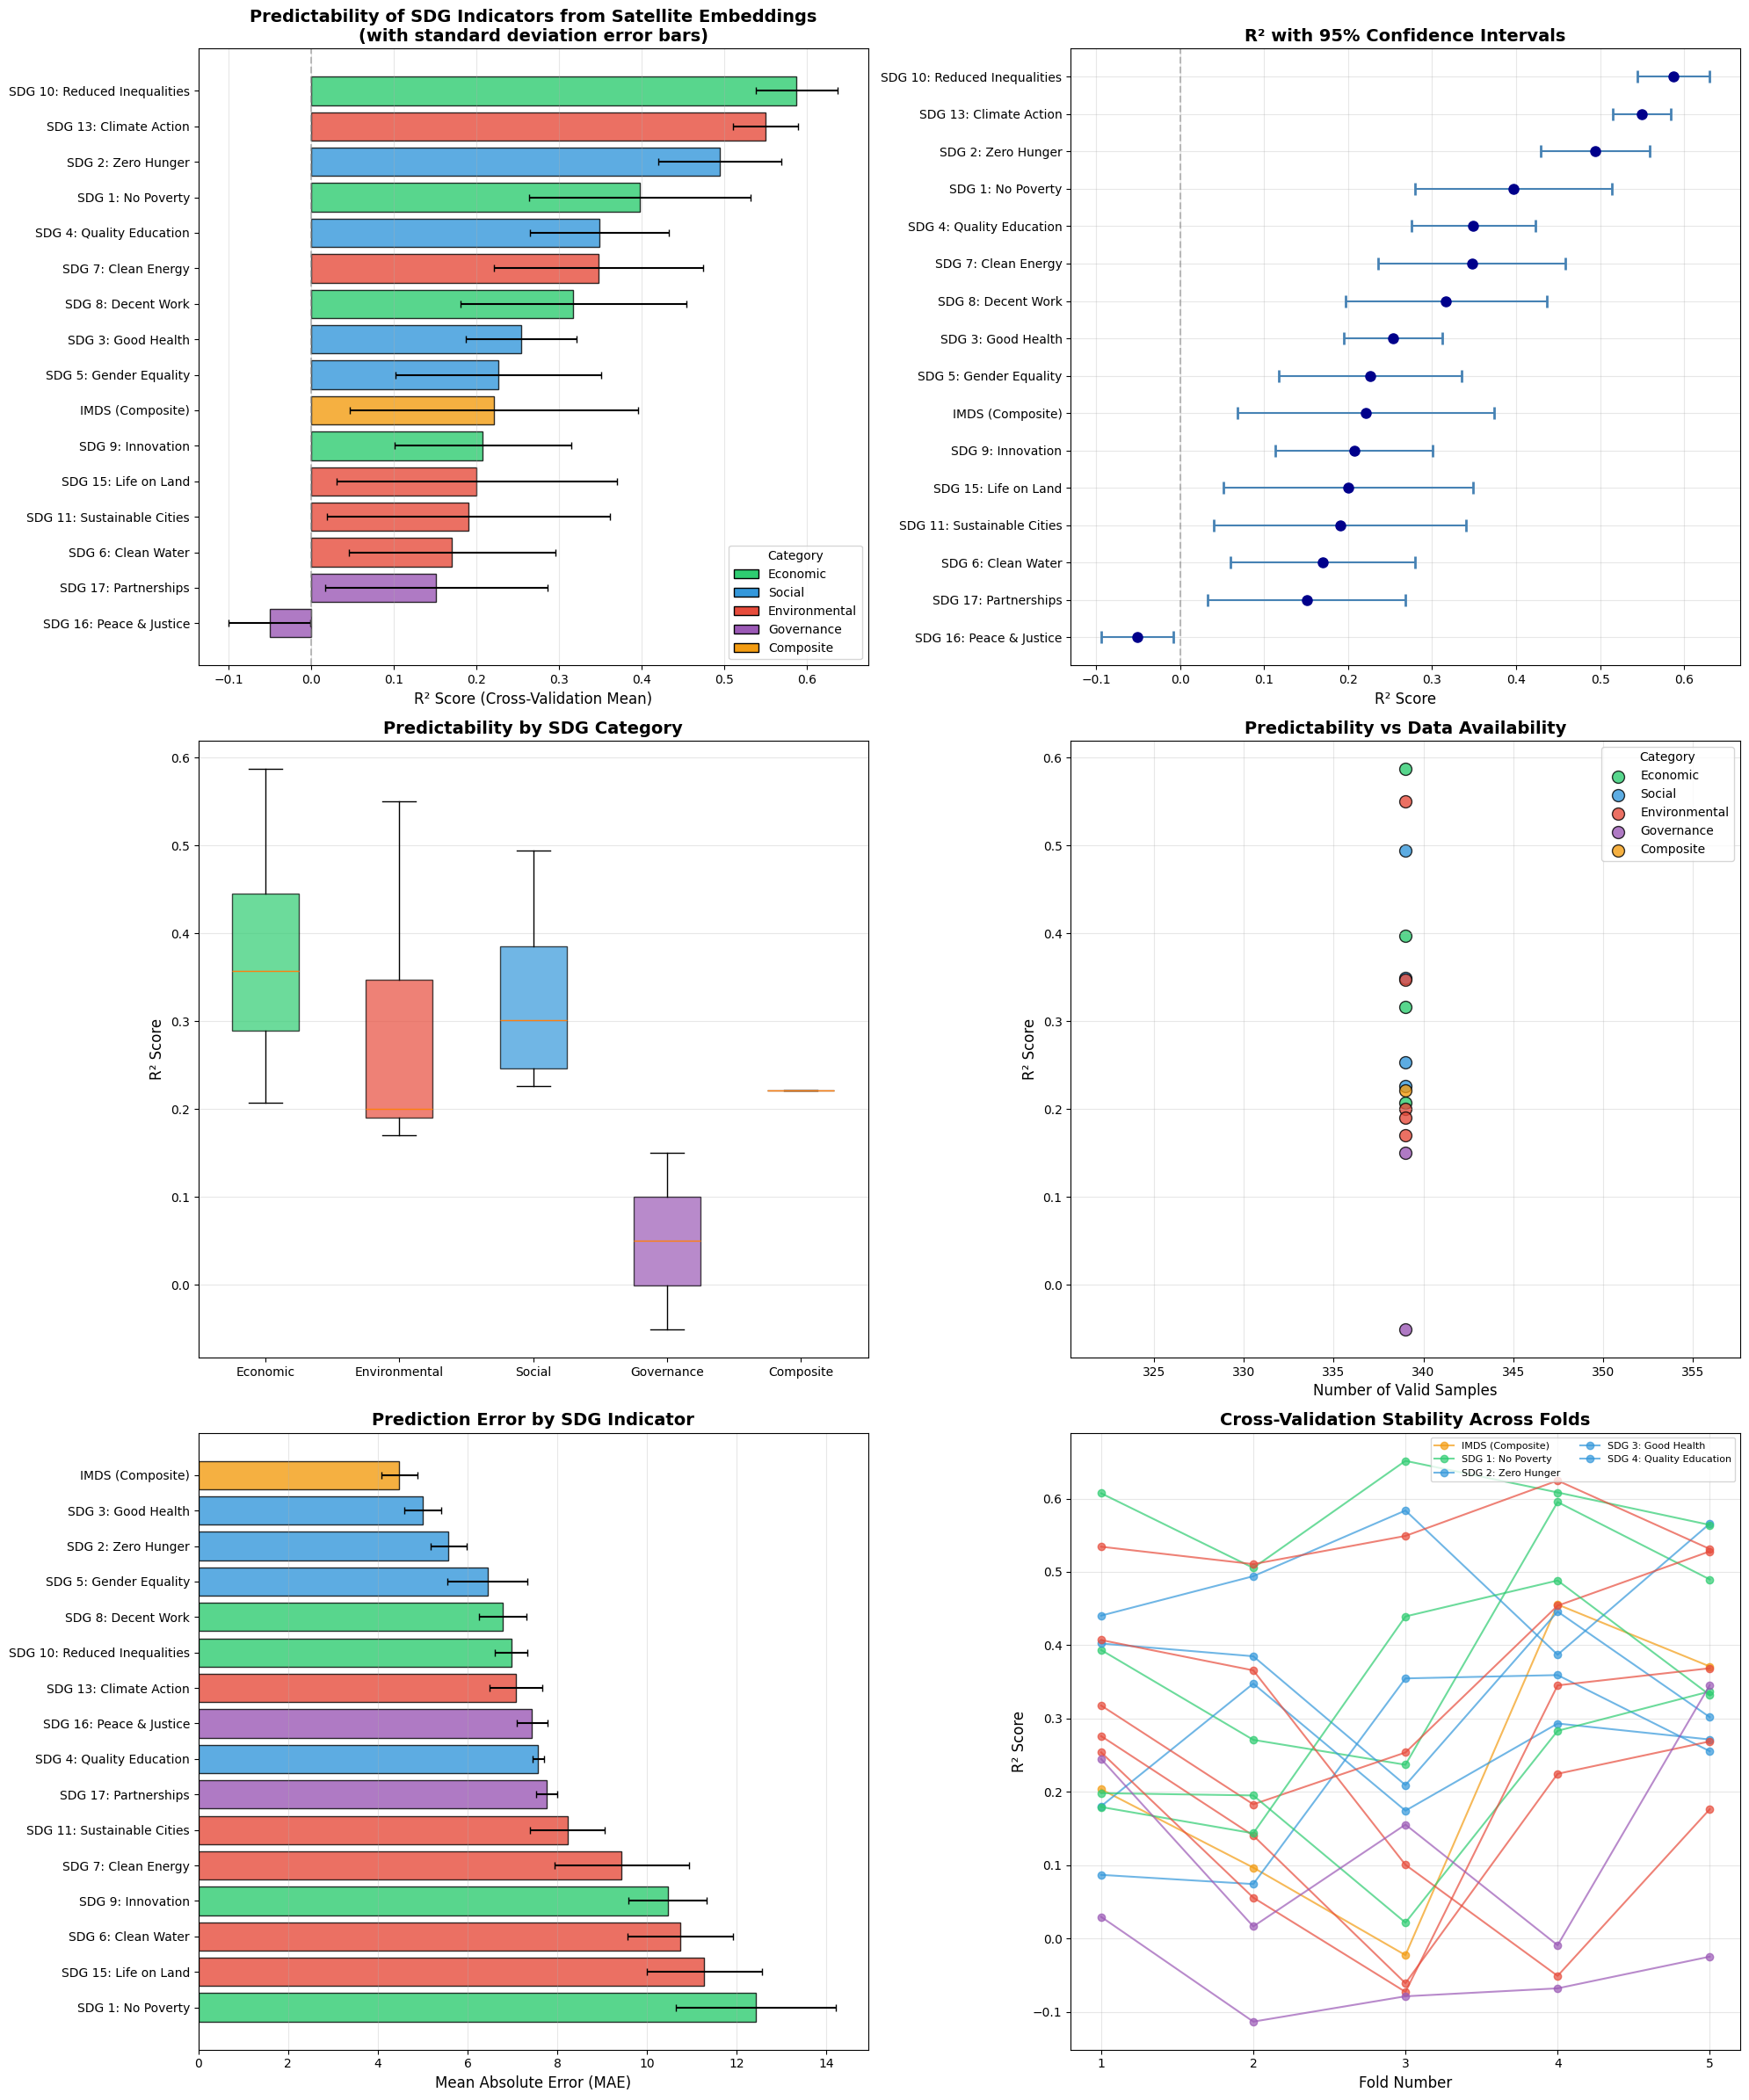


Visualization saved: all_sdgs_comparison.png


In [16]:
# Set up the figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# Color palette for categories
category_colors = {
    'Economic': '#2ecc71',
    'Social': '#3498db',
    'Environmental': '#e74c3c',
    'Governance': '#9b59b6',
    'Composite': '#f39c12'
}

# ============================================================
# Plot 1: R² Comparison (Horizontal Bar Chart)
# ============================================================
ax1 = plt.subplot(3, 2, 1)

# Sort by R² for display
df_sorted = df_results.sort_values('r2_mean', ascending=True)

colors = [category_colors[cat] for cat in df_sorted['category']]
bars = ax1.barh(range(len(df_sorted)), df_sorted['r2_mean'],
                xerr=df_sorted['r2_std'], capsize=3, color=colors, edgecolor='black', alpha=0.8)

ax1.set_yticks(range(len(df_sorted)))
ax1.set_yticklabels(df_sorted['description'], fontsize=10)
ax1.set_xlabel('R² Score (Cross-Validation Mean)', fontsize=12)
ax1.set_title('Predictability of SDG Indicators from Satellite Embeddings\n(with standard deviation error bars)',
              fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3, axis='x')

# Add legend for categories
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=cat)
                   for cat, color in category_colors.items()]
ax1.legend(handles=legend_elements, loc='lower right', title='Category')

# ============================================================
# Plot 2: R² with 95% Confidence Intervals
# ============================================================
ax2 = plt.subplot(3, 2, 2)

x_pos = range(len(df_sorted))
ax2.errorbar(df_sorted['r2_mean'], x_pos,
             xerr=[df_sorted['r2_mean'] - df_sorted['r2_ci_lower'],
                   df_sorted['r2_ci_upper'] - df_sorted['r2_mean']],
             fmt='o', capsize=5, capthick=2, markersize=8,
             color='darkblue', ecolor='steelblue')

ax2.set_yticks(x_pos)
ax2.set_yticklabels(df_sorted['description'], fontsize=10)
ax2.set_xlabel('R² Score', fontsize=12)
ax2.set_title('R² with 95% Confidence Intervals', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

# ============================================================
# Plot 3: Category Comparison (Box Plot)
# ============================================================
ax3 = plt.subplot(3, 2, 3)

category_order = ['Economic', 'Environmental', 'Social', 'Governance', 'Composite']
df_plot = df_results[df_results['category'].isin(category_order)].copy()

# Create box plot data
box_data = [df_plot[df_plot['category'] == cat]['r2_mean'].values for cat in category_order if cat in df_plot['category'].values]
box_labels = [cat for cat in category_order if cat in df_plot['category'].values]
box_colors = [category_colors[cat] for cat in box_labels]

bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_ylabel('R² Score', fontsize=12)
ax3.set_title('Predictability by SDG Category', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# ============================================================
# Plot 4: R² vs Sample Size
# ============================================================
ax4 = plt.subplot(3, 2, 4)

for cat in category_colors:
    mask = df_results['category'] == cat
    ax4.scatter(df_results.loc[mask, 'n_samples'],
                df_results.loc[mask, 'r2_mean'],
                c=category_colors[cat], label=cat, s=100, edgecolors='black', alpha=0.8)

ax4.set_xlabel('Number of Valid Samples', fontsize=12)
ax4.set_ylabel('R² Score', fontsize=12)
ax4.set_title('Predictability vs Data Availability', fontsize=14, fontweight='bold')
ax4.legend(title='Category')
ax4.grid(True, alpha=0.3)

# ============================================================
# Plot 5: MAE Comparison
# ============================================================
ax5 = plt.subplot(3, 2, 5)

df_mae_sorted = df_results.sort_values('mae_mean', ascending=False)
colors_mae = [category_colors[cat] for cat in df_mae_sorted['category']]

ax5.barh(range(len(df_mae_sorted)), df_mae_sorted['mae_mean'],
         xerr=df_mae_sorted['mae_std'], capsize=3, color=colors_mae, edgecolor='black', alpha=0.8)

ax5.set_yticks(range(len(df_mae_sorted)))
ax5.set_yticklabels(df_mae_sorted['description'], fontsize=10)
ax5.set_xlabel('Mean Absolute Error (MAE)', fontsize=12)
ax5.set_title('Prediction Error by SDG Indicator', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# ============================================================
# Plot 6: Fold-by-Fold Stability
# ============================================================
ax6 = plt.subplot(3, 2, 6)

# Plot R² across folds for each SDG
for i, r in enumerate(all_results):
    color = category_colors[r['category']]
    ax6.plot(range(1, N_OUTER_FOLDS + 1), r['fold_r2_scores'],
             marker='o', label=r['description'] if i < 5 else None,
             color=color, alpha=0.7)

ax6.set_xlabel('Fold Number', fontsize=12)
ax6.set_ylabel('R² Score', fontsize=12)
ax6.set_title('Cross-Validation Stability Across Folds', fontsize=14, fontweight='bold')
ax6.set_xticks(range(1, N_OUTER_FOLDS + 1))
ax6.grid(True, alpha=0.3)
ax6.legend(loc='upper right', fontsize=8, ncol=2)

plt.tight_layout()
plt.savefig('all_sdgs_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved: all_sdgs_comparison.png")

## 7. Feature Importance Analysis

Let's analyze which satellite embedding dimensions are most predictive across all SDGs.

In [17]:
# Create feature importance matrix (16 SDGs × 64 features)
feature_importance_df = pd.DataFrame(
    feature_importance_matrix,
    columns=FEATURE_COLS,
    index=[r['target'] for r in all_results]
)

print(f"Feature importance matrix shape: {feature_importance_df.shape}")
print(f"  - Rows: {feature_importance_df.shape[0]} SDG indicators")
print(f"  - Columns: {feature_importance_df.shape[1]} satellite features")

Feature importance matrix shape: (16, 64)
  - Rows: 16 SDG indicators
  - Columns: 64 satellite features


In [18]:
# Calculate aggregate importance across all SDGs
aggregate_importance = feature_importance_df.mean(axis=0).sort_values(ascending=False)

print("\nTOP 20 MOST IMPORTANT FEATURES (AVERAGED ACROSS ALL SDGs)")
print("-" * 60)
print(f"{'Rank':<6} {'Feature':<10} {'Importance':<12} {'Cumulative %'}")
print("-" * 60)

cumulative = 0
for i, (feat, imp) in enumerate(aggregate_importance.head(20).items()):
    cumulative += imp
    print(f"{i+1:<6} {feat:<10} {imp:.6f}     {cumulative*100:.2f}%")

# How many features for 80% importance?
cumsum = np.cumsum(aggregate_importance.values)
n_features_80 = np.argmax(cumsum >= 0.80) + 1
print(f"\nFeatures needed for 80% total importance: {n_features_80}/64 ({n_features_80/64*100:.1f}%)")


TOP 20 MOST IMPORTANT FEATURES (AVERAGED ACROSS ALL SDGs)
------------------------------------------------------------
Rank   Feature    Importance   Cumulative %
------------------------------------------------------------
1      A58        0.026072     2.61%
2      A23        0.025117     5.12%
3      A59        0.024603     7.58%
4      A30        0.024444     10.02%
5      A43        0.024140     12.44%
6      A62        0.024066     14.84%
7      A42        0.022383     17.08%
8      A37        0.021725     19.26%
9      A32        0.018917     21.15%
10     A50        0.018536     23.00%
11     A33        0.018500     24.85%
12     A21        0.018399     26.69%
13     A18        0.018136     28.50%
14     A13        0.017875     30.29%
15     A57        0.017740     32.07%
16     A47        0.017327     33.80%
17     A52        0.017126     35.51%
18     A54        0.016995     37.21%
19     A04        0.016819     38.89%
20     A38        0.016715     40.56%

Features needed f

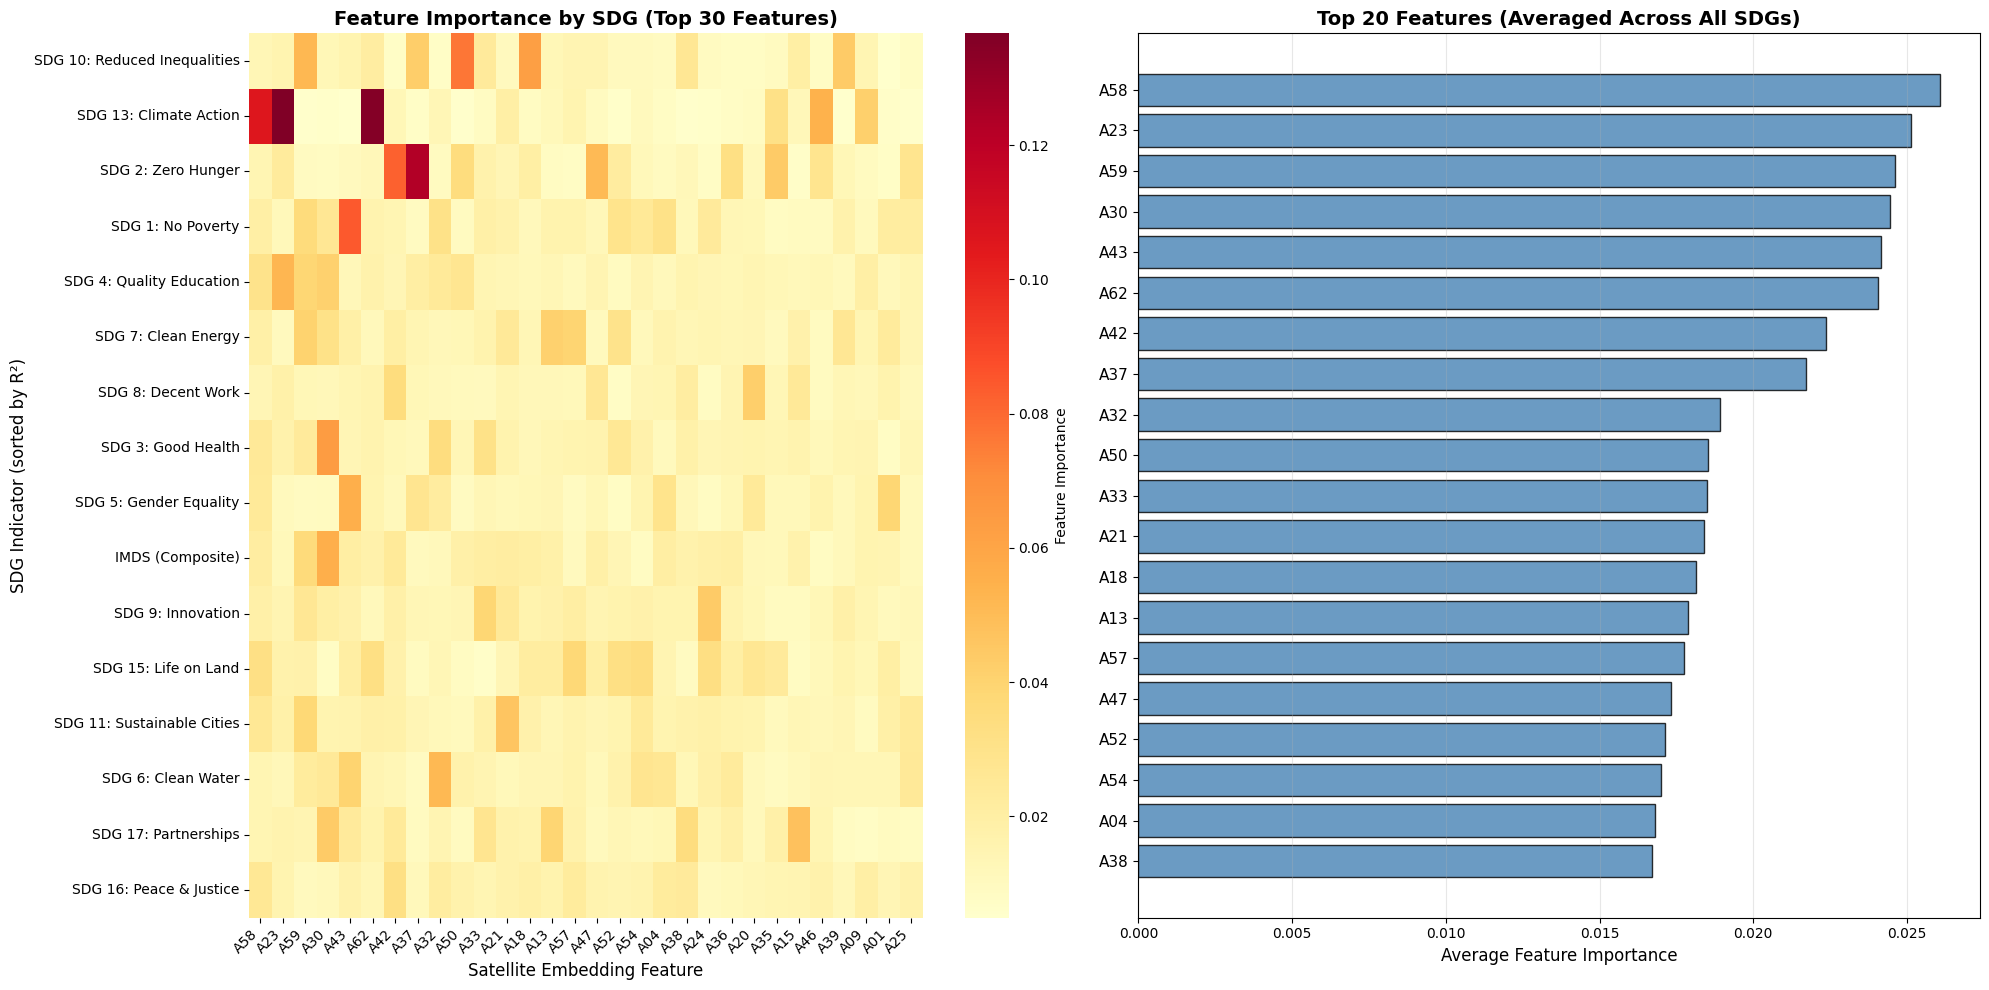


Visualization saved: feature_importance_analysis.png


In [19]:
# Create feature importance heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap: All features × All SDGs
ax1 = axes[0]

# Sort features by aggregate importance and SDGs by R²
top_features = aggregate_importance.head(30).index.tolist()
sdg_order = df_results.sort_values('r2_mean', ascending=False)['variable'].tolist()

heatmap_data = feature_importance_df.loc[sdg_order, top_features]

sns.heatmap(heatmap_data, ax=ax1, cmap='YlOrRd',
            xticklabels=top_features,
            yticklabels=[SDG_DESCRIPTIONS[v] for v in sdg_order],
            cbar_kws={'label': 'Feature Importance'})
ax1.set_title('Feature Importance by SDG (Top 30 Features)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Satellite Embedding Feature', fontsize=12)
ax1.set_ylabel('SDG Indicator (sorted by R²)', fontsize=12)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Bar chart: Aggregate importance
ax2 = axes[1]

top_20_features = aggregate_importance.head(20)
bars = ax2.barh(range(len(top_20_features)), top_20_features.values,
                color='steelblue', edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(top_20_features)))
ax2.set_yticklabels(top_20_features.index, fontsize=11)
ax2.set_xlabel('Average Feature Importance', fontsize=12)
ax2.set_title('Top 20 Features (Averaged Across All SDGs)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved: feature_importance_analysis.png")

In [20]:
# Identify SDG-specific vs universal features
print("\nFEATURE SPECIFICITY ANALYSIS")
print("="*80)

# Calculate coefficient of variation for each feature across SDGs
feature_cv = feature_importance_df.std(axis=0) / feature_importance_df.mean(axis=0)
feature_cv = feature_cv.sort_values()

print("\nMost UNIVERSAL features (low variance across SDGs):")
print("-" * 50)
for feat in feature_cv.head(10).index:
    mean_imp = feature_importance_df[feat].mean()
    std_imp = feature_importance_df[feat].std()
    print(f"  {feat}: importance = {mean_imp:.4f} (±{std_imp:.4f})")

print("\nMost SDG-SPECIFIC features (high variance across SDGs):")
print("-" * 50)
for feat in feature_cv.tail(10).index[::-1]:
    mean_imp = feature_importance_df[feat].mean()
    std_imp = feature_importance_df[feat].std()
    # Find which SDG uses this feature most
    top_sdg = feature_importance_df[feat].idxmax()
    print(f"  {feat}: importance = {mean_imp:.4f} (±{std_imp:.4f}) | Most important for: {SDG_DESCRIPTIONS[top_sdg]}")


FEATURE SPECIFICITY ANALYSIS

Most UNIVERSAL features (low variance across SDGs):
--------------------------------------------------
  A55: importance = 0.0123 (±0.0022)
  A29: importance = 0.0111 (±0.0023)
  A40: importance = 0.0127 (±0.0027)
  A11: importance = 0.0138 (±0.0031)
  A34: importance = 0.0126 (±0.0029)
  A51: importance = 0.0126 (±0.0030)
  A48: importance = 0.0127 (±0.0031)
  A45: importance = 0.0114 (±0.0028)
  A60: importance = 0.0118 (±0.0029)
  A56: importance = 0.0105 (±0.0027)

Most SDG-SPECIFIC features (high variance across SDGs):
--------------------------------------------------
  A37: importance = 0.0217 (±0.0285) | Most important for: SDG 2: Zero Hunger
  A23: importance = 0.0251 (±0.0313) | Most important for: SDG 13: Climate Action
  A62: importance = 0.0241 (±0.0300) | Most important for: SDG 13: Climate Action
  A50: importance = 0.0185 (±0.0172) | Most important for: SDG 10: Reduced Inequalities
  A58: importance = 0.0261 (±0.0221) | Most important for:

## 8. Hyperparameter Analysis

Let's examine the optimal hyperparameters found for each SDG and identify patterns.

In [21]:
# Extract best hyperparameters (using first fold's params as representative)
hyperparam_data = []

for r in all_results:
    # Average across folds for each hyperparameter
    avg_params = {}
    for param in ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight',
                  'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda', 'gamma']:
        values = [fold_params.get(param, np.nan) for fold_params in r['best_params_per_fold']]
        avg_params[param] = np.mean(values)

    avg_params['sdg'] = r['target']
    avg_params['description'] = r['description']
    avg_params['r2'] = r['r2_mean']
    hyperparam_data.append(avg_params)

df_hyperparams = pd.DataFrame(hyperparam_data)
df_hyperparams = df_hyperparams.sort_values('r2', ascending=False)

In [22]:
# Display hyperparameter summary
print("\nOPTIMAL HYPERPARAMETERS BY SDG")
print("="*100)

display_params = ['description', 'r2', 'n_estimators', 'max_depth', 'learning_rate', 'subsample']
print(df_hyperparams[display_params].to_string(index=False))


OPTIMAL HYPERPARAMETERS BY SDG
                 description        r2  n_estimators  max_depth  learning_rate  subsample
SDG 10: Reduced Inequalities  0.587309         440.0        8.8       0.021845   0.832568
      SDG 13: Climate Action  0.549976         210.0        7.6       0.027916   0.783119
          SDG 2: Zero Hunger  0.494248         200.0        6.2       0.030625   0.727426
           SDG 1: No Poverty  0.397340         280.0        7.6       0.039881   0.667019
    SDG 4: Quality Education  0.348914         260.0        9.2       0.014502   0.713404
         SDG 7: Clean Energy  0.347348         320.0        6.2       0.032155   0.728930
          SDG 8: Decent Work  0.316605         240.0        9.0       0.034029   0.777354
          SDG 3: Good Health  0.253504         270.0       10.0       0.011399   0.731663
      SDG 5: Gender Equality  0.226213         160.0        8.2       0.027337   0.782716
            IMDS (Composite)  0.220932         250.0        6.2     

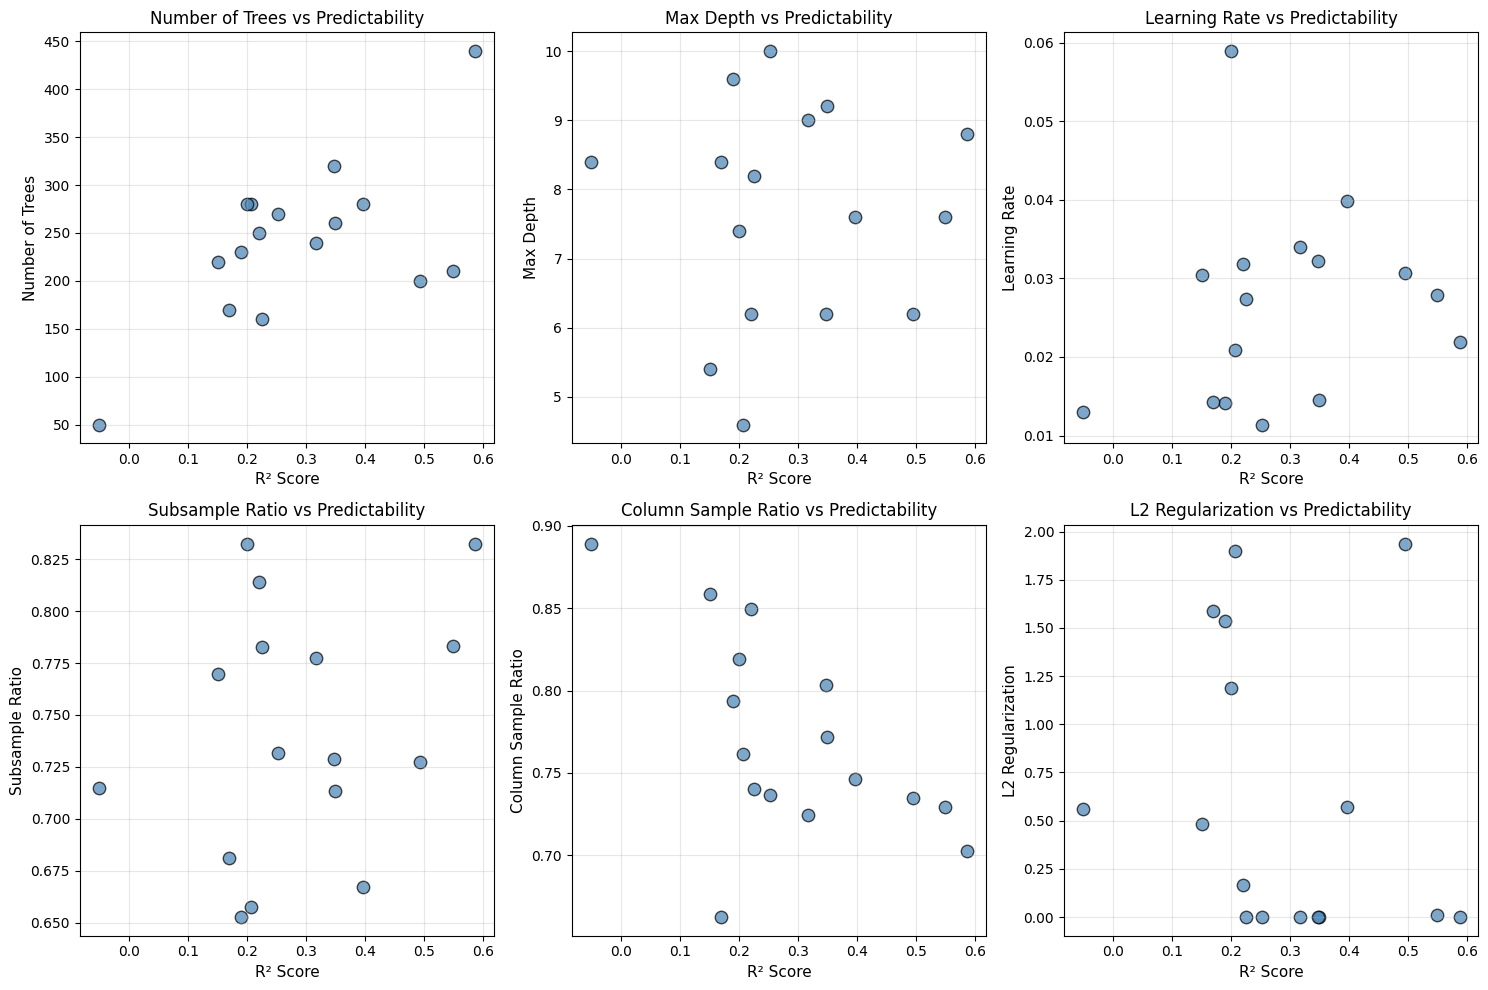


Visualization saved: hyperparameter_analysis.png


In [23]:
# Visualize hyperparameter patterns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

params_to_plot = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'reg_lambda']
param_labels = ['Number of Trees', 'Max Depth', 'Learning Rate', 'Subsample Ratio', 'Column Sample Ratio', 'L2 Regularization']

for ax, param, label in zip(axes.flat, params_to_plot, param_labels):
    ax.scatter(df_hyperparams['r2'], df_hyperparams[param],
               c='steelblue', s=80, edgecolors='black', alpha=0.7)
    ax.set_xlabel('R² Score', fontsize=11)
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(f'{label} vs Predictability', fontsize=12)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hyperparameter_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved: hyperparameter_analysis.png")

## 9. Interpretation & Discussion

### Key Findings

In [24]:
# Generate interpretive summary
print("="*80)
print("KEY FINDINGS: SATELLITE EMBEDDINGS FOR SDG PREDICTION IN BOLIVIA")
print("="*80)

# Top 3 most predictable SDGs
top_3 = df_results.nsmallest(3, 'rank')
print("\n1. MOST PREDICTABLE SDGs (highest R²):")
print("-" * 60)
for _, row in top_3.iterrows():
    print(f"   {row['rank']}. {row['description']}")
    print(f"      R² = {row['r2_mean']:.4f} (95% CI: {row['r2_ci_lower']:.4f} - {row['r2_ci_upper']:.4f})")
    print(f"      MAE = {row['mae_mean']:.2f}")

# Bottom 3 least predictable SDGs
bottom_3 = df_results.nlargest(3, 'rank')
print("\n2. LEAST PREDICTABLE SDGs (lowest R²):")
print("-" * 60)
for _, row in bottom_3.iterrows():
    print(f"   {row['rank']}. {row['description']}")
    print(f"      R² = {row['r2_mean']:.4f} (95% CI: {row['r2_ci_lower']:.4f} - {row['r2_ci_upper']:.4f})")
    print(f"      MAE = {row['mae_mean']:.2f}")

# Category summary
print("\n3. PREDICTABILITY BY CATEGORY:")
print("-" * 60)
cat_means = df_results.groupby('category')['r2_mean'].mean().sort_values(ascending=False)
for cat, r2 in cat_means.items():
    n_sdgs = (df_results['category'] == cat).sum()
    print(f"   {cat:<15} | Mean R² = {r2:.4f} | ({n_sdgs} SDGs)")

# Feature insights
print("\n4. FEATURE IMPORTANCE INSIGHTS:")
print("-" * 60)
print(f"   - Top 3 features: {', '.join(aggregate_importance.head(3).index.tolist())}")
print(f"   - Features for 80% importance: {n_features_80}/64 ({n_features_80/64*100:.1f}%)")

# Statistical summary
print("\n5. OVERALL STATISTICS:")
print("-" * 60)
print(f"   - Mean R² across all SDGs: {df_results['r2_mean'].mean():.4f}")
print(f"   - Median R²: {df_results['r2_mean'].median():.4f}")
print(f"   - R² range: [{df_results['r2_mean'].min():.4f}, {df_results['r2_mean'].max():.4f}]")
print(f"   - SDGs with R² > 0.3: {(df_results['r2_mean'] > 0.3).sum()}/{len(df_results)}")
print(f"   - SDGs with R² > 0.2: {(df_results['r2_mean'] > 0.2).sum()}/{len(df_results)}")

KEY FINDINGS: SATELLITE EMBEDDINGS FOR SDG PREDICTION IN BOLIVIA

1. MOST PREDICTABLE SDGs (highest R²):
------------------------------------------------------------
   1. SDG 10: Reduced Inequalities
      R² = 0.5873 (95% CI: 0.5440 - 0.6306)
      MAE = 6.97
   2. SDG 13: Climate Action
      R² = 0.5500 (95% CI: 0.5156 - 0.5844)
      MAE = 7.07
   3. SDG 2: Zero Hunger
      R² = 0.4942 (95% CI: 0.4292 - 0.5593)
      MAE = 5.58

2. LEAST PREDICTABLE SDGs (lowest R²):
------------------------------------------------------------
   16. SDG 16: Peace & Justice
      R² = -0.0509 (95% CI: -0.0940 - -0.0077)
      MAE = 7.44
   15. SDG 17: Partnerships
      R² = 0.1507 (95% CI: 0.0329 - 0.2686)
      MAE = 7.77
   14. SDG 6: Clean Water
      R² = 0.1699 (95% CI: 0.0603 - 0.2795)
      MAE = 10.75

3. PREDICTABILITY BY CATEGORY:
------------------------------------------------------------
   Economic        | Mean R² = 0.3771 | (4 SDGs)
   Social          | Mean R² = 0.3307 | (4 SDGs

### Interpretation Framework

**Why are some SDGs more predictable than others?**

1. **High predictability SDGs** (R² > 0.35):
   - Likely related to **visible infrastructure** (buildings, roads, electricity)
   - Correlate with **land use patterns** (urban vs rural)
   - Reflect **physical development** captured by satellite imagery

2. **Low predictability SDGs** (R² < 0.15):
   - Related to **social outcomes** (education quality, gender equality)
   - Depend on **institutional factors** not visible from space
   - Require **survey data** not captured by remote sensing

**Policy Implications:**
- Satellite data can help **target interventions** for infrastructure-related SDGs
- For social SDGs, traditional surveys remain essential
- Combining satellite and survey data may improve predictions

## 10. Export Results

Let's save all results for further analysis and reporting.

In [25]:
# Export 1: Main results table
export_cols = ['rank', 'variable', 'description', 'category', 'n_samples',
               'r2_mean', 'r2_std', 'r2_ci_lower', 'r2_ci_upper',
               'rmse_mean', 'rmse_std', 'mae_mean', 'mae_std', 'predictability']
df_results[export_cols].to_csv('all_sdg_results.csv', index=False)
print("Saved: all_sdg_results.csv")

# Export 2: Feature importance matrix
feature_importance_df.to_csv('all_sdg_feature_importance.csv')
print("Saved: all_sdg_feature_importance.csv")

# Export 3: Aggregate feature importance
aggregate_importance.to_frame('importance').to_csv('aggregate_feature_importance.csv')
print("Saved: aggregate_feature_importance.csv")

# Export 4: Best hyperparameters
df_hyperparams.to_csv('best_hyperparameters.csv', index=False)
print("Saved: best_hyperparameters.csv")

# Export 5: Summary as JSON
summary_json = {
    'methodology': {
        'algorithm': 'XGBoost',
        'gpu_accelerated': GPU_AVAILABLE,
        'outer_folds': N_OUTER_FOLDS,
        'inner_folds': N_INNER_FOLDS,
        'optuna_trials': N_TRIALS,
        'n_features': 64,
        'n_targets': len(TARGET_VARIABLES),
        'total_execution_time_minutes': total_time / 60
    },
    'overall_statistics': {
        'mean_r2': float(df_results['r2_mean'].mean()),
        'median_r2': float(df_results['r2_mean'].median()),
        'min_r2': float(df_results['r2_mean'].min()),
        'max_r2': float(df_results['r2_mean'].max()),
        'sdgs_above_0.3': int((df_results['r2_mean'] > 0.3).sum()),
        'sdgs_above_0.2': int((df_results['r2_mean'] > 0.2).sum()),
    },
    'top_features': aggregate_importance.head(10).to_dict(),
    'features_for_80pct': int(n_features_80),
}

with open('analysis_summary.json', 'w') as f:
    json.dump(summary_json, f, indent=2)
print("Saved: analysis_summary.json")

Saved: all_sdg_results.csv
Saved: all_sdg_feature_importance.csv
Saved: aggregate_feature_importance.csv
Saved: best_hyperparameters.csv
Saved: analysis_summary.json


In [26]:
# Generate markdown summary table for publications
print("\n" + "="*80)
print("PUBLICATION-READY SUMMARY TABLE (Markdown)")
print("="*80 + "\n")

markdown_table = "| Rank | SDG Indicator | Category | R² (95% CI) | MAE | Predictability |\n"
markdown_table += "|------|---------------|----------|-------------|-----|----------------|\n"

for _, row in df_results.iterrows():
    ci_str = f"{row['r2_mean']:.3f} ({row['r2_ci_lower']:.3f}-{row['r2_ci_upper']:.3f})"
    markdown_table += f"| {row['rank']} | {row['description']} | {row['category']} | {ci_str} | {row['mae_mean']:.2f} | {row['predictability']} |\n"

print(markdown_table)

# Save to file
with open('summary_table.md', 'w') as f:
    f.write("# Comparative SDG Predictability from Satellite Embeddings\n\n")
    f.write("## Results Summary\n\n")
    f.write(markdown_table)
    f.write("\n\n*Generated using XGBoost with nested cross-validation and Optuna hyperparameter tuning.*\n")

print("\nSaved: summary_table.md")


PUBLICATION-READY SUMMARY TABLE (Markdown)

| Rank | SDG Indicator | Category | R² (95% CI) | MAE | Predictability |
|------|---------------|----------|-------------|-----|----------------|
| 1 | SDG 10: Reduced Inequalities | Economic | 0.587 (0.544-0.631) | 6.97 | High |
| 2 | SDG 13: Climate Action | Environmental | 0.550 (0.516-0.584) | 7.07 | High |
| 3 | SDG 2: Zero Hunger | Social | 0.494 (0.429-0.559) | 5.58 | High |
| 4 | SDG 1: No Poverty | Economic | 0.397 (0.280-0.515) | 12.43 | Medium |
| 5 | SDG 4: Quality Education | Social | 0.349 (0.275-0.423) | 7.57 | Medium |
| 6 | SDG 7: Clean Energy | Environmental | 0.347 (0.236-0.459) | 9.44 | Medium |
| 7 | SDG 8: Decent Work | Economic | 0.317 (0.197-0.436) | 6.79 | Medium |
| 8 | SDG 3: Good Health | Social | 0.254 (0.195-0.312) | 5.00 | Medium |
| 9 | SDG 5: Gender Equality | Social | 0.226 (0.117-0.335) | 6.44 | Low |
| 10 | IMDS (Composite) | Composite | 0.221 (0.068-0.374) | 4.48 | Low |
| 11 | SDG 9: Innovation | Economi

## 11. Student Exercises

Try these exercises to deepen your understanding:

### Exercise 1: Model Comparison
Modify the code to also run **LightGBM** and compare its performance with XGBoost. Which algorithm performs better for which SDGs?

### Exercise 2: SHAP Analysis
Install the `shap` library and compute SHAP values for one of the top-performing SDGs. Which features contribute most to individual predictions?

```python
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=FEATURE_COLS)
```

### Exercise 3: Spatial Cross-Validation
The current analysis uses random splits. Implement **spatial cross-validation** using geographic coordinates to avoid spatial leakage. Does performance change?

### Exercise 4: Feature Engineering
Create new features by:
- Adding polynomial interactions between top features
- Including night-time lights data
- Adding geographic coordinates (latitude, longitude)

Does performance improve?

### Exercise 5: Prediction Maps
For the best-performing SDG, create a choropleth map showing:
- Actual values
- Predicted values
- Prediction errors

Where does the model perform well vs poorly spatially?

## 12. References

### Methodological References

- Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. *KDD '16*.
- Akiba, T., et al. (2019). Optuna: A Next-generation Hyperparameter Optimization Framework. *KDD '19*.
- Varma, S., & Simon, R. (2006). Bias in error estimation when using cross-validation for model selection. *BMC Bioinformatics*.

### Domain References

- Jean, N., et al. (2016). Combining satellite imagery and machine learning to predict poverty. *Science*.
- Yeh, C., et al. (2020). Using publicly available satellite imagery and deep learning to understand economic well-being in Africa. *Nature Communications*.
- Andersen, L. E., et al. (2020). Atlas municipal de los Objetivos de Desarrollo Sostenible en Bolivia 2020.

### Citation

If you use this analysis, please cite:

```
Mendez, C., Gonzales, E., Leoni, P., Andersen, L., Peralta, H. (2026).
DS4Bolivia: A Data Science Repository to Study GeoSpatial Development in Bolivia
[Data set]. GitHub. https://github.com/quarcs-lab/ds4bolivia
```

In [27]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nFiles generated:")
print("  1. all_sdgs_comparison.png - Main comparison visualization")
print("  2. feature_importance_analysis.png - Feature importance heatmap")
print("  3. hyperparameter_analysis.png - Hyperparameter patterns")
print("  4. all_sdg_results.csv - Complete results table")
print("  5. all_sdg_feature_importance.csv - Feature importance matrix")
print("  6. aggregate_feature_importance.csv - Averaged feature importance")
print("  7. best_hyperparameters.csv - Optimal hyperparameters per SDG")
print("  8. analysis_summary.json - Summary statistics")
print("  9. summary_table.md - Publication-ready markdown table")
print("\nThank you for using DS4Bolivia!")


ANALYSIS COMPLETE!

Files generated:
  1. all_sdgs_comparison.png - Main comparison visualization
  2. feature_importance_analysis.png - Feature importance heatmap
  3. hyperparameter_analysis.png - Hyperparameter patterns
  4. all_sdg_results.csv - Complete results table
  5. all_sdg_feature_importance.csv - Feature importance matrix
  6. aggregate_feature_importance.csv - Averaged feature importance
  7. best_hyperparameters.csv - Optimal hyperparameters per SDG
  8. analysis_summary.json - Summary statistics
  9. summary_table.md - Publication-ready markdown table

Thank you for using DS4Bolivia!
